<a href="https://colab.research.google.com/github/pedrogasg/manning-rl-liveproject/blob/master/self-driving-vehicles/deliverable_milestone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tensorflow==1.15.3 > /dev/null 2>&1

In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.3


In [3]:
!pip install git+https://github.com/eleurent/highway-env > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install stable-baselines==2.10.0 > /dev/null 2>&1

In [ ]:
!pip install stable-baselines[mpi] --upgrade  > /dev/null 2>&1

In [3]:
import gym
import highway_env

from stable_baselines import HER, SAC

from tqdm.notebook import trange

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
from pathlib import Path
import base64

In [4]:
!git clone https://github.com/eleurent/highway-env.git
import sys
sys.path.insert(0, './highway-env/scripts/')
from utils import record_videos, show_videos, capture_intermediate_frames

fatal: destination path 'highway-env' already exists and is not an empty directory.


In [5]:
def learn_model(policy, env):
  model = HER('MlpPolicy', env, policy, n_sampled_goal=4,
              goal_selection_strategy='future',
              verbose=1, buffer_size=int(1e6),
              learning_rate=1e-3,
              gamma=0.9, batch_size=256,
              policy_kwargs=dict(layers=[256, 256, 256]))
  model.learn(32768)
  return model

In [6]:
def eval_her_video(env, model):
  renv = record_videos(env)

  for episode in trange(5, desc="Output Episodes"):
    obs, done = renv.reset(), False
    capture_intermediate_frames(renv)
    while not done:
      action, _  = model.predict(obs)
      obs, reward, done, info = renv.step(action)

  renv.close()

  show_videos()

In [7]:
env = gym.make("parking-v0")

model_sac = learn_model(SAC, env)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




------------------------------------------
| current_lr              | 0.001        |
| ent_coef                | 0.0036620763 |
| ent_coef_loss           | -0.7871504   |
| entropy                 | 1.1244045    |
| episodes                | 100          |
| fps                     | 28           |
| mean 100 episode reward | -41.7        |
| n_updates               | 9634         |
| policy_loss             | 2.0957565    |
| qf1_loss                | 0.0061302064 |
| qf2_loss                | 0.005146204  |
| success rate            | 0.04         |
| time_elapsed            | 340          |
| total timesteps         | 9733         |
| value_loss              | 0.0063731167 |
-------------

In [8]:
eval_her_video(env, model_sac)

In [9]:
from stable_baselines import TD3

model_td3 = learn_model(TD3, env)

-----------------------------------------
| current_lr              | 0.001       |
| episodes                | 100         |
| fps                     | 36          |
| mean 100 episode reward | -50.6       |
| n_updates               | 9900        |
| qf1_loss                | 0.032385755 |
| qf2_loss                | 0.032543726 |
| success rate            | 0.01        |
| time_elapsed            | 271         |
| total timesteps         | 9918        |
-----------------------------------------
-----------------------------------------
| current_lr              | 0.001       |
| episodes                | 200         |
| fps                     | 36          |
| mean 100 episode reward | -41.3       |
| n_updates               | 19800       |
| qf1_loss                | 0.031258464 |
| qf2_loss                | 0.031720456 |
| success rate            | 0.01        |
| time_elapsed            | 539         |
| total timesteps         | 19831       |
----------------------------------

In [10]:
eval_her_video(env, model_td3)

In [12]:
from stable_baselines import DDPG

def learn_model_notlr(policy, env):
  model = HER('MlpPolicy', env, policy, n_sampled_goal=4,
              goal_selection_strategy='future',
              verbose=1, buffer_size=int(1e6),
              gamma=0.9, batch_size=256,
              policy_kwargs=dict(layers=[256, 256, 256]))
  model.learn(32768)
  return model

model_ddpg = learn_model_notlr(DDPG, env)



--------------------------------------
| reference_Q_mean        | -1       |
| reference_Q_std         | 0.685    |
| reference_action_mean   | 0.167    |
| reference_action_std    | 0.808    |
| reference_actor_Q_mean  | -0.965   |
| reference_actor_Q_std   | 0.683    |
| rollout/Q_mean          | -1.02    |
| rollout/actions_mean    | 0.0513   |
| rollout/actions_std     | 0.626    |
| rollout/episode_steps   | 100      |
| rollout/episodes        | 100      |
| rollout/return          | -53.5    |
| rollout/return_history  | -53.5    |
| success rate            | 0        |
| total/duration          | 205      |
| total/episodes          | 100      |
| total/epochs            | 1        |
| total/steps             | 9998     |
| total/steps_per_second  | 48.7     |
| train/loss_actor        | 0.997    |
| train/loss_critic       | 0.0067   |
| train/param_noise_di... | 0        |
--------------------------------------

--------------------------------------
| reference_Q_mean    

In [13]:
eval_her_video(env, model_ddpg)

In [14]:
def avereging(model, env, times):
  rewards = []
  for episode in trange(times, desc="Output Episodes"):
    obs, done, total = env.reset(), False, 0
    while not done:
      action, _  = model.predict(obs)
      obs, reward, done, info = env.step(action)
      total += reward
    rewards.append(total)

  average = (sum(rewards)/len(rewards))
  env.close()
  return rewards, average

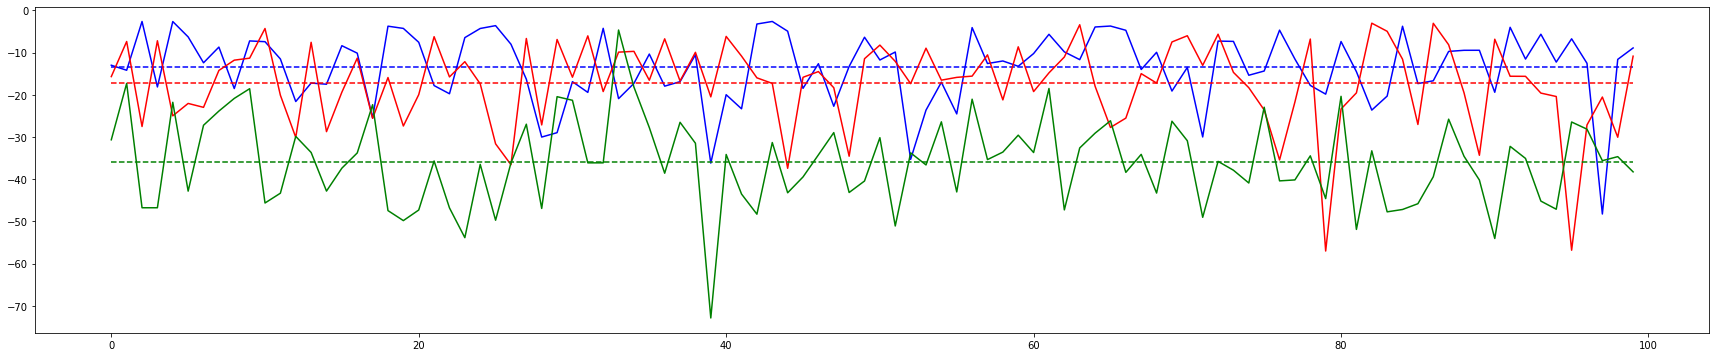

In [15]:
import matplotlib.pyplot as plt
import numpy as np
times = 100
sac_rs, sac_a = avereging(model_sac, env, times)
td3_rs, td3_a = avereging(model_td3, env, times)
ddpg_rs, ddpg_a = avereging(model_ddpg, env, times)

sac_as = np.repeat(sac_a, times)
td3_as = np.repeat(td3_a, times)
ddpg_as = np.repeat(ddpg_a, times)

x = np.arange(times)

plt.figure(figsize=(30,6))
plt.plot(x, sac_rs, label='SAC Rewards', color="b")
plt.plot(x, sac_as, '--', label='SAC Average', color="b")
plt.plot(x, td3_rs, label='TD3 Rewards', color="r")
plt.plot(x, td3_as, '--', label='TD3 Average', color="r")
plt.plot(x, ddpg_rs, label='DDPG Rewards', color="g")
plt.plot(x, ddpg_as, '--', label='DDPG Average', color="g")